In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = torch.linspace(-10,10,200).reshape(-1,1)

In [3]:
y=(np.sin(5*(np.pi*X)))/((5*(np.pi*X)))

In [4]:
# Calculating number of parameters in the MODEL
def CalcParams(model):
    val = sum(params.numel() for params in model.parameters() if params.requires_grad)
    return val

In [5]:
#Creating Model
class Model(nn.Module):
    def __init__(self, in_features=1, h1=4, h2=8, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_features)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model=Model()

In [7]:
model

Model(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

In [8]:
modelparams=CalcParams(model)
print(modelparams)

57


In [9]:
lay1_cons = 1 * 4
lay2_cons = 4 * 8
lay3_cons = 8 * 1
tot_mod_cons = lay1_cons + lay2_cons + lay3_cons


In [10]:
crit_loss = nn.CrossEntropyLoss()

In [11]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
no_iterations=8
epochs = 30
epoch_num=round(epochs/3)
mod_losses = []
c=0
lay2_weights_tensor = torch.zeros((no_iterations * epoch_num, lay2_cons))
whole_mod_weights_tensor = torch.zeros((no_iterations * epoch_num, tot_mod_cons))
loss_tensor = torch.zeros((no_iterations * epoch_num, 1))
for train in range(no_iterations):
    model=Model()
    crit_loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(epochs):
        i+=1
        # feed forward
        y_pred = model.forward(X)
        # compute error
        trn_loss = crit_loss(y_pred, y)
        mod_losses.append(trn_loss)
        
        optim.zero_grad()
        trn_loss.backward()
        optim.step()
        
        # for every 3 epochs, collect weights and loss of the model
        if i % 3 == 0:
            # collect weights of the model
            lay1_weights = torch.reshape(torch.flatten(model.fc1.weight), (1, lay1_cons))
            lay2_weights  = torch.reshape(torch.flatten(model.fc2.weight), (1, lay2_cons))
            lay3_weights  = torch.reshape(torch.flatten(model.fc3.weight), (1, lay3_cons))
            # Combine all layers weights for the whole model
            sum_lay1_lay2 = torch.cat((lay2_weights , lay1_weights), dim=1)
            whole_mod_weights = torch.cat((sum_lay1_lay2, lay3_weights), dim=1)
            # Save weights and loss 
            whole_mod_weights_tensor[c] = whole_mod_weights
            lay2_weights_tensor[c] = lay2_weights
            loss_tensor[c] = trn_loss
            c += 1

In [13]:
# Implementation of PCA 
def PcaImplem(inp_arr, dim_to_ret):
    m, n = inp_arr.shape
    
    means_inp = np.array([np.mean(inp_arr[:, i]) for i in range(n)])
    inp_norm = inp_arr - means_inp
    
    # Calculating egn values and egn vectors
    matrix = np.dot(np.transpose(inp_norm),inp_norm)
    egn_vals, egn_vctrs = np.linalg.eig(matrix)
    pairs = [(np.abs(egn_vals[i]), egn_vctrs[:, i]) for i in range(n)]

    # Sorting pairs and return dimensions requested
    pairs.sort(key=lambda x: x[0], reverse=True)
    feat_from_data = np.array([value[1] for value in pairs[:dim_to_ret]])
    red_dim_data = np.dot(inp_norm, np.transpose(feat_from_data))
    return red_dim_data

In [14]:
# Reducing the dimensions using PCA
lay2_reduced = lay2_weights_tensor.detach().cpu().numpy()
whole_mod_red = whole_mod_weights_tensor.detach().cpu().numpy()
loss_vector = loss_tensor.detach().cpu().numpy()
lay2_reduced  = PcaImplem(lay2_reduced , 2)
whole_mod_red = PcaImplem(whole_mod_red, 2)

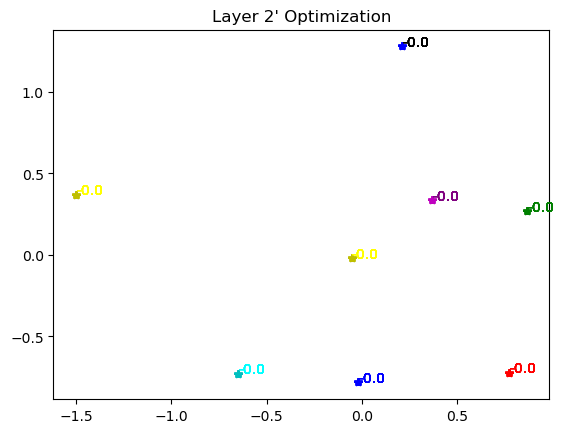

In [15]:
# Plot optimization of Layer 2 of Neural Network
colour_list = ['y*', 'b*', 'g*', 'r*', 'c*', 'b*', 'm*']
colour_name_list = ["yellow", "blue", "green", "red", "cyan", "black", 'purple']
c = 0
clr_cntr = 0
for pair in lay2_reduced:
    if (c % 10) == 0 and c != 0:
        # then change colour
        if clr_cntr >= len(colour_list) - 1:
            clr_cntr= 0
        else:
            clr_cntr += 1
    plt.plot(pair[0], pair[1], colour_list[clr_cntr])
    plt.annotate(str(round(loss_vector[c][0], 2)), (pair[0], pair[1]), color=colour_name_list[clr_cntr])
    c += 1
plt.title("Layer 2' Optimization") 
plt.show()

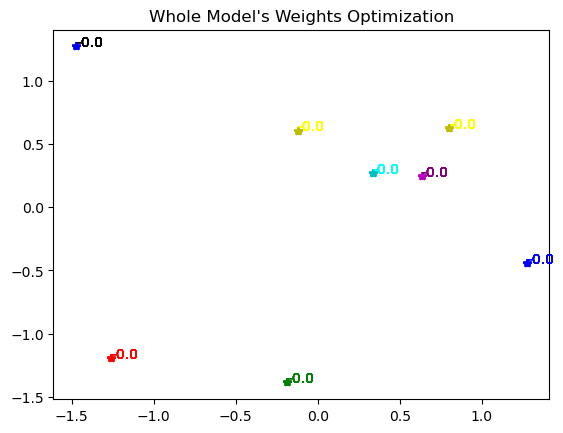

In [16]:
# Plot optimization of Whole Model of Neural Network
c = 0
clr_cntr = 0
for pair in whole_mod_red:
    if (c % 10) == 0 and c != 0:
        if clr_cntr >= len(colour_list) - 1:
            clr_cntr = 0
        else:
            clr_cntr += 1
    plt.plot(pair[0], pair[1], colour_list[clr_cntr ])
    plt.annotate(str(round(loss_vector[c][0], 2)), (pair[0], pair[1]), color=colour_name_list[clr_cntr])
    c += 1
plt.title("Whole Model's Weights Optimization")
plt.show()